In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import random

In [2]:
df_hol= pd.read_csv('E:\Applications\工作\金融\RPIA\second round interview\\rpia-quant-test-master\\rpia-quant-test-master\\data\\holdings.csv')
df_met = pd.read_csv('E:\Applications\工作\金融\RPIA\second round interview\\rpia-quant-test-master\\rpia-quant-test-master\\data\\metrics.csv')
df_sec = pd.read_csv('E:\Applications\工作\金融\RPIA\second round interview\\rpia-quant-test-master\\rpia-quant-test-master\\data\\security.csv')
pd.set_option('display.max_rows', 63)

In [3]:
"""data preprocessing, notice that bond 20489 has different number of data point in df_hol and df_met,excess data points in df_met were removed""" 
df_hol = df_hol.pivot(index = 'Day', columns = 'ID',values = 'Quantity')
ID = df_hol.columns.tolist()
Day = df_hol.index.values.tolist()

In [4]:
# the data index for removing in 24089
index_del = list(range(1048,1071))
df_met.drop(index = index_del,inplace=True)
df_met.index = range(len(df_met['ID']))

In [5]:
#add Day column into df_met
Day_series = []
for id in ID:
    Day_series.extend(df_hol.loc[pd.notna(df_hol.loc[:,id]),id].index)
Day_series = pd.DataFrame(Day_series,columns = ['Day'])
df_met= pd.concat([df_met,Day_series],axis = 1)

In [6]:
"""calcule the price return index and total return index according S&P Dow Jones indices:Fixed Income Index Mathematics Methodology"""
# generate price table from df_met
df_price = df_met.pivot(index = 'Day', columns = 'ID',values = 'Price')
# ceate df_weight to store individual security weight for each day
df_weight = df_hol.copy()
for day in Day:
    for id in ID:
        df_weight.loc[day,id]=df_price.loc[day,id]*df_hol.loc[day,id]
df_weight['total_volume'] = df_weight.sum(axis = 1)
for day in Day:
    for id in ID:
        df_weight.loc[day,id] = df_weight.loc[day,id]/df_weight.loc[day,'total_volume']
df_weight.fillna(0,inplace = True)
# AccruedInterest table
df_ai = df_met.pivot(index = 'Day', columns = 'ID',values = 'AccruedInterest')
df_ai.fillna(0,inplace = True)
# ceate df_pr to store individual security price return for each day
df_pr = df_price.copy()
for day in range(1,len(Day)):
    for id in range(len(ID)):
        df_pr.iloc[day,id]=(df_price.iloc[day,id]-df_price.iloc[day-1,id])/(df_price.iloc[day,id]+df_ai.iloc[day,id])
df_pr.fillna(0,inplace = True)
# Yeild table
df_yield = df_met.pivot(index = 'Day', columns = 'ID',values = 'Yield')
df_yield.fillna(0,inplace = True)

In [7]:
#coupon return table
df_cr = df_price.copy()
for day in Day:
    for id in ID:
        df_cr.loc[day,id]=df_yield.loc[day,id]*df_price.loc[day,id]/100/365
# df_ir to store individual interest return for each day
df_ir = df_price.copy()
for day in range(1,len(Day)):
    for id in range(len(ID)):
        df_ir.iloc[day,id]=(df_ai.iloc[day,id]-df_ai.iloc[day-1,id]+df_cr.iloc[day,id])/(df_price.iloc[day,id]+df_ai.iloc[day,id])
df_ir.fillna(0,inplace = True)
# df_tr to store individual interest return for each day
df_tr = df_price.copy()
for day in range(len(Day)):
    for id in range(len(ID)):
        df_tr.iloc[day,id]=df_pr.iloc[day,id]+df_ir.iloc[day,id]

In [8]:
# calculate the price return index with initial value of 100
index_pr =[100]
pr = [0]
for day in range(1,len(Day)):
    indexpr = 0
    for id in range(len(ID)):
        indexpr+=df_weight.iloc[day-1,id]*df_pr.iloc[day,id]
    pr.append(indexpr)
    cur = index_pr[-1]*(1+indexpr)
    index_pr.append(cur)

In [9]:
# calculate the total return index with initial value of 100
index_tol =[100]
tr = [0]
for day in range(1,len(Day)):
    index_cur = 0
    for id in range(len(ID)):
        index_cur+=df_weight.iloc[day-1,id]*df_tr.iloc[day,id]
    tr.append(index_cur)
    cur = index_tol[-1]*(1+index_cur)
    index_tol.append(cur)

In [10]:
"""calculate the index duration""" 
# generate modified duration table from df_met
df_MD = df_met.pivot(index = 'Day', columns = 'ID',values = 'ModifiedDuration')
df_MD.fillna(0,inplace = True)

In [11]:
#initialize list for index_MD
index_MD = []
for day in Day:
    cur = 0
    for id in ID:
        cur+=df_weight.loc[day,id]*df_MD.loc[day,id]
    index_MD.append(cur)

# the index metrics
index =pd.DataFrame(list(zip(Day,index_pr,pr, index_tol,tr,index_MD)), columns = ['Day','price return index','price return','total return index','total return','index duration'])
index.set_index('Day',inplace = True)
index.loc[2,'price return'] = index.loc[3,'price return']
index.loc[2,'total return'] = index.loc[3,'total return']


In [12]:
# index.head(5)

In [13]:
df_term = df_met.pivot(index = 'Day', columns = 'ID',values = 'Term')
df_weight['short_term_weight']=0
df_weight['intermediate_term_weight']=0
df_weight['long_term_weight']=0

In [14]:
# the tensor buckets can be determined as less than 3 years as short-term, 3-7 years as intermediate term, and larger than 7 years as long-term
# calculate the weight and duration of different tenors in index

for day in Day:
    bond_list_short_term = df_term.columns[(df_term.loc[day,:]<=3)].tolist()
    bond_list_intermediate_term  = df_term.columns[((df_term.loc[day,:]>3)&(df_term.loc[day,:]<=7))].tolist()
    bond_list_long_term = df_term.columns[(df_term.loc[day,:]>7)].tolist()
    df_weight.loc[day,'short_term_weight'] = df_weight.loc[day,bond_list_short_term].sum()
    df_weight.loc[day,'intermediate_term_weight'] = df_weight.loc[day,bond_list_intermediate_term].sum()
    df_weight.loc[day,'long_term_weight'] = df_weight.loc[day,bond_list_long_term].sum()
    
    df_weight.loc[day,'short_term_duration'] = df_weight.loc[day,bond_list_short_term].dot(df_MD.loc[day,bond_list_short_term])/df_weight.loc[day,bond_list_short_term].sum()
    df_weight.loc[day,'intermediate_term_duration'] = df_weight.loc[day,bond_list_intermediate_term].dot(df_MD.loc[day,bond_list_intermediate_term])/df_weight.loc[day,bond_list_intermediate_term].sum()
    df_weight.loc[day,'long_term_duration'] = df_weight.loc[day,bond_list_long_term].dot(df_MD.loc[day,bond_list_long_term])/df_weight.loc[day,bond_list_long_term].sum()

    
"""according to the index weight, we roughtly expect our portforlio have 35%  in short_term bond,20% in intermdeiate_term bond and 45% in long_term bond"""
# df_tenor_bucket contains the information about the weight and duration in different tenors for INDEX
df_tenor_bucket = df_weight[['short_term_weight','intermediate_term_weight','long_term_weight','short_term_duration','intermediate_term_duration','long_term_duration']]
# df_tenor_bucket.head(5)

In [15]:
# optimizer function
def optimizer(day,bond_list_short_term,bond_list_intermediate_term,bond_list_long_term):
    """w1,w2,w3 are vairbale vectors represent the weight in short_term,intermediate_term and long_term bond"""
    n1 = len(bond_list_short_term)
    n2 = len(bond_list_intermediate_term)
    n3 = len(bond_list_long_term)
    w1 = cp.Variable(n1)
    w2 = cp.Variable(n2)
    w3 = cp.Variable(n3)
    ret1 = df_tr.loc[day,bond_list_short_term].to_numpy()
    ret2 = df_tr.loc[day,bond_list_intermediate_term].to_numpy()
    ret3 = df_tr.loc[day,bond_list_long_term].to_numpy()
    dur1 = df_MD.loc[day,bond_list_short_term].to_numpy()
    dur2 = df_MD.loc[day,bond_list_intermediate_term].to_numpy()
    dur3 = df_MD.loc[day,bond_list_long_term].to_numpy()
    #minimize the difference in return between portfolio and index
    tracking_error = ret1.T@w1+ret2.T@w2+ret3.T@w3-index.loc[day,'total return']
    #minimize the difference in the weight between portfolio and index 
    diff_in_weight = (cp.norm(cp.sum(w1)-df_tenor_bucket.loc[day,'short_term_weight'],1)
                      +cp.norm(cp.sum(w2)-df_tenor_bucket.loc[day,'intermediate_term_weight'],1)
                      +cp.norm(cp.sum(w3)-df_tenor_bucket.loc[day,'long_term_weight'],1)
                     )
    #minimize the duration difference between portfolio and bentchmark and following the duration matching strategy to control the IR exposure to different tenors.
    diff_in_duration = (cp.norm(dur1.T@w1-df_tenor_bucket.loc[day,'short_term_duration']*df_tenor_bucket.loc[day,'short_term_weight'],1)
                       +cp.norm(dur2.T@w2-df_tenor_bucket.loc[day,'intermediate_term_duration']*df_tenor_bucket.loc[day,'intermediate_term_weight'],1)
                       +cp.norm(dur3.T@w3-df_tenor_bucket.loc[day,'long_term_duration']*df_tenor_bucket.loc[day,'long_term_weight'],1)
                       )
    
    objective = cp.Minimize(cp.norm(tracking_error,1)+diff_in_duration+diff_in_weight)
    #tracking_error>=0 ganrantee the portfolio outperform with respect to the benchmark
    constrain = [cp.sum(w1)+cp.sum(w2)+cp.sum(w3)==1,w1>=0,w2>=0,w3>=0,tracking_error>=0]
    prob = cp.Problem(objective,constrain)
    opt_val = prob.solve()
    return w1.value,w2.value,w3.value

In [16]:
# select the bond for short_term, intermediate_term and long_term respectively to construct the portfolio
day =2
bond_list_short_term = df_term.columns[(df_term.loc[day,:]<=3)].tolist()
bond_list_intermediate_term  = df_term.columns[((df_term.loc[day,:]>3)&(df_term.loc[day,:]<=7))].tolist()
bond_list_long_term = df_term.columns[(df_term.loc[day,:]>7)].tolist()
# num represents the number of bonds in each tenor buckets
num = 3
# here we randomly select bonds in each tenor buckets
random.seed(300)
bond_list_short_term = random.choices(bond_list_short_term,k=num)
bond_list_intermediate_term  = random.choices(bond_list_intermediate_term,k=num)
bond_list_long_term = random.choices(bond_list_long_term,k=num)

portfolio_MD_diff_term = [[0,0,0]]
portfolio_weight = [[0,0,0]]
portfolio_return = [0]
portfolio_duration = [0]
portfolio_daily_weight_for_each_bond = []
# calculate the constructed portfolio parameters, such as weight, return,duration
for day in Day[1:]:
    w=[]
    ret1 = df_tr.loc[day,bond_list_short_term].to_numpy()
    ret2 = df_tr.loc[day,bond_list_intermediate_term].to_numpy()
    ret3 = df_tr.loc[day,bond_list_long_term].to_numpy()
    dur1 = df_MD.loc[day,bond_list_short_term].to_numpy()
    dur2 = df_MD.loc[day,bond_list_intermediate_term].to_numpy()
    dur3 = df_MD.loc[day,bond_list_long_term].to_numpy()
    w1,w2,w3 = optimizer(day,bond_list_short_term,bond_list_intermediate_term,bond_list_long_term)
    w.extend(w1)
    w.extend(w2)
    w.extend(w3)
    portfolio_daily_weight_for_each_bond.append(w)
    portfolio_weight.append([sum(w1),sum(w2),sum(w3)])
    portfolio_MD_diff_term.append([np.dot(w1,dur1)/sum(w1),np.dot(w2,dur2)/sum(w2),np.dot(w3,dur3)/sum(w3)])
    portfolio_return.append(np.dot(ret1,w1)+np.dot(ret2,w2)+np.dot(ret3,w3))
    portfolio_duration.append(np.dot(w1,dur1)+np.dot(w2,dur2)+np.dot(w3,dur3))

In [17]:
# the portfolio metrics along time
portfolio = pd.DataFrame(list(zip(Day,portfolio_weight,portfolio_return,portfolio_MD_diff_term,portfolio_duration)),columns = ['Day','weight','portforlio_return','duration_tenor','portforlio_duration'])
portfolio[['duration_short_term','duration_intermediate_term','duration_long_term']] = pd.DataFrame(portfolio.duration_tenor.tolist(), index= portfolio.index)
portfolio[['weight_short_term','weight_intermediate_term','weight_long_term']] = pd.DataFrame(portfolio.weight.tolist(), index= portfolio.index)
portfolio.drop(['weight','duration_tenor'],axis =1,inplace = True)
portfolio.set_index('Day',inplace = True)
portfolio.loc[2,:] = portfolio.loc[3,:]

In [18]:
# portfolio changes in weight for each bond
portfolio_weight_evolving = pd.DataFrame(list(zip(Day,portfolio_daily_weight_for_each_bond)),columns = ['Day','Weight'])
name = ['1_bond_short_term','2_bond_short_term','3_bond_short_term','1_bond_intermediate_term','2_bond_intermediate_term','3_bond_intermediate_term','1_bond_long_term','2_bond_long_term','3_bond_long_term']
portfolio_weight_evolving[name] = pd.DataFrame(portfolio_weight_evolving.Weight.tolist(), index= portfolio_weight_evolving.index)
portfolio_weight_evolving.drop('Weight',axis = 1, inplace = True)
portfolio_weight_evolving.set_index('Day',inplace = True)
# portfolio_weight_evolving

In [19]:
# portforlio.head(5)

In [20]:
# index.head(5)

In [21]:
# df_tenor_bucket.head(5)

Text(0.5, 1.0, 'portfolio_return vs index_total_return')

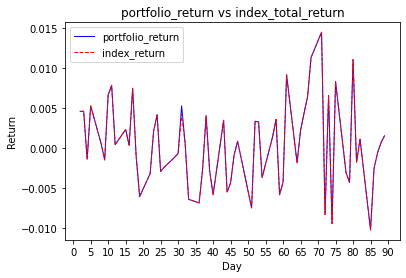

In [22]:
# draw figure for comparing portofolio return and index return
plt.plot(portfolio.index, portfolio.loc[:,'portforlio_return'],linewidth=1, color = 'blue',linestyle='solid',label = 'portfolio_return')
plt.plot(index.index, index.loc[:,'total return'],color = 'red',linewidth=1,linestyle='dashed',label = 'index_return')
plt.xticks(np.arange(0, 95, step=5))
plt.xlabel("Day")
plt.ylabel("Return")
plt.legend()
plt.title('portfolio_return vs index_total_return')

Text(0.5, 1.0, 'portfolio_duration vs index_duration')

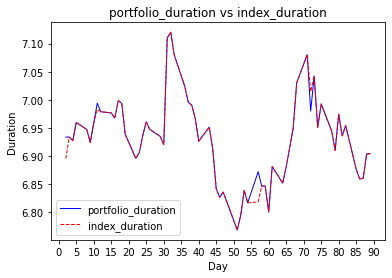

In [23]:
# draw figure for comparing portfolio duration and index duration
plt.plot(portfolio.index, portfolio.loc[:,'portforlio_duration'],linewidth=1, color = 'blue',linestyle='solid',label = 'portfolio_duration')
plt.plot(index.index, index.loc[:,'index duration'],color = 'red',linewidth=1,linestyle='dashed',label = 'index_duration')
plt.xticks(np.arange(0, 95, step=5))
plt.xlabel("Day")
plt.ylabel("Duration")
plt.legend()
plt.title('portfolio_duration vs index_duration')

Text(0.5, 1.0, 'daily trades on each bond')

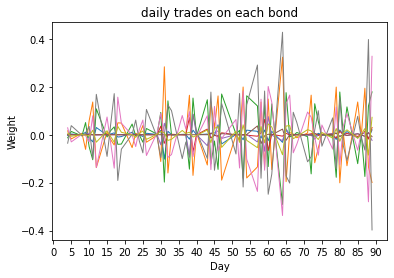

In [24]:
# according to the duration matching strategy, we allocate the different weight for the bonds in the tenors. The allocations for each bond on a daily base can be found in portfolio_weight_evolving
# From portfolio_weight_evolving, we generate daily rebalancing trades for portfolio in order to track the index changes
daily_rebalancing_trades = portfolio_weight_evolving[name].diff()
plt.plot(portfolio.index[1:], daily_rebalancing_trades,linewidth=1)
plt.xticks(np.arange(0, 95, step=5))
plt.xlabel('Day')
plt.ylabel('Weight')
plt.title('daily trades on each bond')